# IC50 Prediction for M. tuberculosis InhA Inhibitors - Data Cleaning and Feature Engineering

### Import the Necessary Libraries

In [1]:
# Basic Python Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# visualization style
sns.set()
sns.set_palette("husl")

In [3]:
#  ChEMBL and PDB Access Libraries
from chembl_webresource_client.new_client import new_client
import Bio.PDB as pdb
from Bio.PDB import *

In [4]:
# Chemistry Libraries
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

In [5]:
# Interactive Visualization Libraries
import py3Dmol
from IPython.display import display, Image

In [6]:
# Additional Utilities
import warnings
import requests
import json
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

In [7]:
# Basic Structure Loading and Visualization
def fetch_and_visualize_1ENY(style='cartoon'):
    
    # Initialize viewer with good dimensions for the structure
    view = py3Dmol.view(width=800, height=600)
    
    # Fetch the 4TRO structure
    url = 'https://files.rcsb.org/view/1ENY.pdb'
    response = requests.get(url)
    
    if response.status_code == 200:
        # Add the structure to the viewer
        view.addModel(response.text, "pdb")
        # Set the initial style
        view.setStyle({'model': -1}, {style: {'colorscheme': 'chainHelix'}})
        # Center the view on the structure
        view.zoomTo()
        return view
    else:
        print("Failed to fetch 1ENY structure")
        return None

In [8]:
# Enhanced Visualization with Multiple Representations
def visualize_1ENY_detailed():
    """
    Creates a detailed visualization of 1ENY showing both the overall structure
    and important details with multiple representations.
    """
    view = py3Dmol.view(width=800, height=600)
    
    # Fetch structure
    response = requests.get('https://files.rcsb.org/view/4TRO.pdb')
    
    if response.status_code == 200:
        # Add the model
        view.addModel(response.text, "pdb")
        
        # Add main cartoon representation with chain-based coloring
        view.setStyle({'model': -1}, {
            'cartoon': {
                'colorscheme': 'chainHelix',
                'opacity': 0.9
            }
        })
        
        # Add transparent surface to show molecular shape
        view.addSurface(py3Dmol.VDW, {
            'opacity': 0.3,
            'color': 'white'
        })
        
        # Center and zoom
        view.zoomTo()
        
        return view
    else:
        print("Failed to fetch 1ENY structure")
        return None

In [9]:
# Structure Analysis for 4TRO
def analyze_1ENY():
    """
    Performs basic analysis of the 1ENY structure and displays key information.
    """
    parser = PDBParser()
    pdbl = PDBList()
    
    # Download the structure
    filename = pdbl.retrieve_pdb_file('1ENY', file_format='pdb', pdir='./temp')
    
    # Parse the structure
    structure = parser.get_structure('1ENY', filename)
    
    # Analyze first model
    model = structure[0]
    
    # Gather information
    info = {
        'chains': len(list(model.get_chains())),
        'residues': sum(1 for _ in model.get_residues()),
        'atoms': sum(1 for _ in model.get_atoms())
    }
    
    # Print analysis
    print("Structure Analysis of 1ENY:")
    print("-" * 30)
    print(f"Number of chains: {info['chains']}")
    print(f"Number of residues: {info['residues']}")
    print(f"Number of atoms: {info['atoms']}")
    
    return info

In [10]:
view = fetch_and_visualize_1ENY()
if view: view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [11]:
info = analyze_1ENY()

Structure exists: './temp\pdb1eny.ent' 
Structure Analysis of 1ENY:
------------------------------
Number of chains: 1
Number of residues: 310
Number of atoms: 2079


In [12]:
# Simple Target Search for Enoyl-ACP Reductase (1ENY)
def search_tb_target():
    """
    Search for Enoyl-ACP Reductase in ChEMBL.
    This enzyme corresponds to PDB structure 1ENY and ChEMBL360.
    """
    target = new_client.target
    result = target.filter(
        pref_name__icontains="enoyl",  # Changed from "transpeptidase"
        organism__icontains="tuberculosis"
    )
    
    # Print what we found
    print("Found targets:")
    for t in result:
        print(f"ID: {t['target_chembl_id']}")
        print(f"Name: {t['pref_name']}\n")
    
    return result

In [13]:
# Simple Activity Data Fetch
def get_compounds(target_id):
    """
    Get compounds and their IC50 values for our target.
    """
    activity = new_client.activity
    results = activity.filter(
        target_chembl_id=target_id,
        standard_type="IC50"
    )
    
    # Convert to DataFrame with just the essential columns
    df = pd.DataFrame([
        {
            'molecule_id': r['molecule_chembl_id'],
            'ic50': r['standard_value'],
            'smiles': r['canonical_smiles']
        }
        for r in results
    ])
    
    print(f"Found {len(df)} compounds")
    return df

In [14]:
targets = search_tb_target()

Found targets:
ID: CHEMBL1849
Name: Enoyl-[acyl-carrier-protein] reductase



In [15]:
compounds = get_compounds("CHEMBL1849")

Found 457 compounds


CHEMBL1849 represents Enoyl-[acyl-carrier-protein] reductase from M. tuberculosis, also known as InhA. This is actually a fascinating target - it's the enzyme responsible for fatty acid biosynthesis in M. tuberculosis and is the target of the front-line TB drug isoniazid.

In [16]:
compounds.head()

,molecule_id,ic50,smiles
0,CHEMBL217926,10660.0,O=C(Nc1ccccc1)C1CC(=O)N(C2CCCCC2)C1
1,CHEMBL216547,100000.0,O=C(Nc1ccccc1Br)C1CC(=O)N(C2CCCCC2)C1
2,CHEMBL213720,100000.0,O=C(Nc1ccc2c(c1)OCCO2)C1CC(=O)N(C2CCCCC2)C1
3,CHEMBL217274,100000.0,Cc1cccc(C)c1NC(=O)C1CC(=O)N(C2CCCCC2)C1
4,CHEMBL217773,100000.0,O=C(Nc1ccc(Oc2ccccc2)cc1)C1CC(=O)N(C2CCCCC2)C1


In [17]:
# Create a profile Report
from ydata_profiling import ProfileReport

profile = ProfileReport(compounds, title='CHEMBL1849 Profiling Report')

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

##### From the ReportProfiling, we can see that we have some duplicate values

In [18]:
compounds = compounds.drop_duplicates(subset=['smiles', 'ic50'])

In [19]:
# Convert IC50 to numeric and remove any invalid values
compounds['ic50'] = pd.to_numeric(compounds['ic50'], errors='coerce')
compounds = compounds.dropna(subset=['ic50'])

In [20]:
# Convert to pIC50 (-log10(IC50)) for better numerical distribution
compounds['pic50'] = -np.log10(compounds['ic50'] * 1e-9)  # Convert to molar units

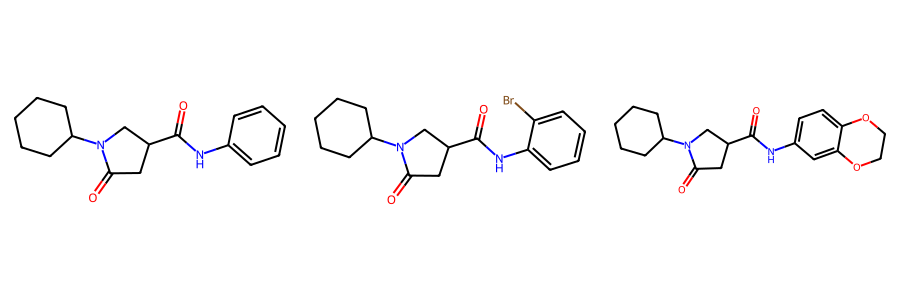

In [21]:
# View first few structures
def show_molecules(smiles_list, n=3):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list[:n]]
    img = Draw.MolsToImage(mols, subImgSize=(300,300))
    return img

# Display first 3 structures
first_three = compounds['smiles'].head(3)
mol_image = show_molecules(first_three)
display(mol_image)

In [22]:
print("Dataset shape after cleaning:", compounds.shape)
print("\nFirst few rows with pIC50 values:")
print(compounds[['molecule_id', 'pic50']].head())

Dataset shape after cleaning: (415, 4)

First few rows with pIC50 values:
    molecule_id     pic50
0  CHEMBL217926  4.972243
1  CHEMBL216547  4.000000
2  CHEMBL213720  4.000000
3  CHEMBL217274  4.000000
4  CHEMBL217773  4.000000


### Feature Engineering

In [23]:
# Ensure 'smiles' column has no NaN values
compounds = compounds.dropna(subset=['smiles']).reset_index(drop=True)

# Keep only valid SMILES (filter out molecules that can't be processed)
valid_smiles = [smile for smile in compounds['smiles'] if Chem.MolFromSmiles(smile) is not None]

# Update `compounds` to contain only valid smiles
compounds_filtered = compounds[compounds['smiles'].isin(valid_smiles)].reset_index(drop=True)

print("Compounds after filtering invalid SMILES:", len(compounds_filtered))

Compounds after filtering invalid SMILES: 415


In [34]:
from rdkit import Chem
from rdkit.Chem import rdmolops

def clean_structures(smiles):
    """Clean chemical structures and handle valence exceptions"""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Remove salts (keep largest fragment)
        frags = Chem.GetMolFrags(mol, asMols=True)
        mol = max(frags, key=lambda m: m.GetNumAtoms())  # Keep largest fragment
        
        # Neutralize charges (basic approach)
        for atom in mol.GetAtoms():
            if atom.GetFormalCharge() != 0:
                atom.SetFormalCharge(0)
        
        # Fix atoms with valence issues (example for Nitrogen)
        for atom in mol.GetAtoms():
            if atom.GetSymbol() == 'N' and atom.GetExplicitValence() > 3:
                atom.SetFormalCharge(0)  # Neutralize by setting formal charge to 0
                if atom.GetImplicitValence() > 1:
                    # Remove excess bonds if possible
                    for neighbor in atom.GetNeighbors():
                        mol.RemoveBond(atom.GetIdx(), neighbor.GetIdx())

        # Sanitize molecule (catch exceptions)
        try:
            rdmolops.SanitizeMol(mol)
        except ValueError as e:
            print(f"Sanitization error: {e}")
            return None
        
        # Generate canonical SMILES
        return Chem.MolToSmiles(mol, canonical=True)
    return None

# Example usage
import pandas as pd
compounds = pd.DataFrame({'smiles': ['C[N+](C)(C)C.[Cl-]', 'CC(=O)OC1=CC=CC=C1C(=O)O']})
compounds['cleaned_smiles'] = compounds['smiles'].apply(clean_structures)

print(compounds)

Sanitization error: Explicit valence for atom # 1 N, 4, is greater than permitted
                     smiles         cleaned_smiles
0        C[N+](C)(C)C.[Cl-]                   None
1  CC(=O)OC1=CC=CC=C1C(=O)O  CC(=O)Oc1ccccc1C(=O)O


[12:04:11] Explicit valence for atom # 1 N, 4, is greater than permitted


In [35]:
# Function to compute molecular descriptors
def get_descriptors(smile):
    mol = Chem.MolFromSmiles(smile)
    return {
        'MW': Descriptors.ExactMolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'TPSA': Descriptors.TPSA(mol),
        'HBA': Descriptors.NumHAcceptors(mol),
        'HBD': Descriptors.NumHDonors(mol),
        'RotBonds': Descriptors.NumRotatableBonds(mol)
    }

# Compute descriptors for valid molecules
desc_df = pd.DataFrame([get_descriptors(smile) for smile in valid_smiles])

print("Descriptor DataFrame shape:", desc_df.shape)


Descriptor DataFrame shape: (415, 6)


In [36]:
# Function to compute Morgan fingerprints
def get_fingerprint(smile):
    mol = Chem.MolFromSmiles(smile)
    return list(AllChem.GetMorganGenerator(radius=2, fpSize=1024).GetFingerprint(mol))

# Generate valid fingerprints
valid_fps = [get_fingerprint(smile) for smile in valid_smiles]

# Create fingerprint DataFrame
fp_df = pd.DataFrame(valid_fps, columns=[f'bit_{i}' for i in range(1024)])

print("Fingerprint DataFrame shape:", fp_df.shape)


Fingerprint DataFrame shape: (415, 1024)


In [37]:
# Combine valid compounds, descriptors, and fingerprints
final_df = pd.concat([compounds_filtered, desc_df, fp_df], axis=1)

print("Final dataset shape:", final_df.shape)

Final dataset shape: (415, 1034)


In [38]:
final_df

,molecule_id,ic50,smiles,pic50,MW,LogP,TPSA,HBA,HBD,RotBonds,...,bit_1014,bit_1015,bit_1016,bit_1017,bit_1018,bit_1019,bit_1020,bit_1021,bit_1022,bit_1023
0,CHEMBL217926,10660.0,O=C(Nc1ccccc1)C1CC(=O)N(C2CCCCC2)C1,4.972243,286.168128,2.80630,49.41,2,1,3,...,0,0,0,0,0,1,0,0,0,0
1,CHEMBL216547,100000.0,O=C(Nc1ccccc1Br)C1CC(=O)N(C2CCCCC2)C1,4.000000,364.078640,3.56880,49.41,2,1,3,...,0,0,0,0,0,1,0,0,0,0
2,CHEMBL213720,100000.0,O=C(Nc1ccc2c(c1)OCCO2)C1CC(=O)N(C2CCCCC2)C1,4.000000,344.173607,2.57750,67.87,4,1,3,...,0,0,0,0,0,1,0,0,0,0
3,CHEMBL217274,100000.0,Cc1cccc(C)c1NC(=O)C1CC(=O)N(C2CCCCC2)C1,4.000000,314.199428,3.42314,49.41,2,1,3,...,0,0,0,0,0,1,0,0,0,0
4,CHEMBL217773,100000.0,O=C(Nc1ccc(Oc2ccccc2)cc1)C1CC(=O)N(C2CCCCC2)C1,4.000000,378.194343,4.59860,58.64,3,1,5,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,CHEMBL5398235,50000.0,Cc1cc(Nc2ccc(N3CCC(c4ccccc4)CC3)cc2)c2cc(Br)cc...,4.301030,471.131010,7.43332,28.16,3,1,4,...,0,0,0,0,0,1,0,0,0,0
411,CHEMBL5430244,4850.0,Cc1cc(Nc2ccc(-n3cccn3)cc2)c2cc(Br)ccc2n1,5.314258,378.048009,5.23502,42.74,4,1,3,...,0,0,0,0,0,0,0,0,0,0
412,CHEMBL5434416,50000.0,Cc1cc(Nc2ccc(N3CCCC3CO)cc2)c2cc(Br)ccc2n1,4.301030,411.094624,5.01042,48.39,4,2,4,...,0,0,0,0,0,1,0,0,0,0
413,CHEMBL5406599,1540.0,CCc1cc(Nc2ccc(N3CCCCC3)cc2)c2cc(Br)ccc2n1,5.812479,409.115360,6.29360,28.16,3,1,4,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# Correlation between molecular descriptors and pIC50
descriptors = ['MW', 'LogP', 'TPSA', 'HBA', 'HBD', 'RotBonds']
correlations = final_df[descriptors + ['pic50']].corr()['pic50'].sort_values()
print("\nCorrelations with pIC50:")
print(correlations)


Correlations with pIC50:
LogP       -0.203622
RotBonds    0.232269
HBD         0.249072
TPSA        0.334183
HBA         0.335906
MW          0.426054
pic50       1.000000
Name: pic50, dtype: float64


In [40]:
final_df = final_df.copy()

In [41]:
final_df.to_csv("final_df.csv", index=False)